In [997]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from PIL import Image, ImageDraw, ImageFont

In [998]:
matplotlib.rc('font', family='Times New Roman')
FONT_PATH = "C:/Windows/Fonts/times.ttf"

In [999]:
try:
    FONT = ImageFont.truetype(FONT_PATH, 22) 
except IOError:
    print(f"Помилка: не вдалося завантажити шрифт зі шляху: {FONT_PATH}")
    print("Текст на зображенні буде відображатися некоректно.")
    FONT = ImageFont.load_default()

In [1000]:
orig_img = cv2.imread("assets/images/photo_2025-05-27_17-02-00.jpg")
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
seg_mask = cv2.imread("assets/results/resnet34/photo_2025-05-27_17-02-00.png")
seg_mask = cv2.cvtColor(seg_mask, cv2.COLOR_BGR2GRAY)

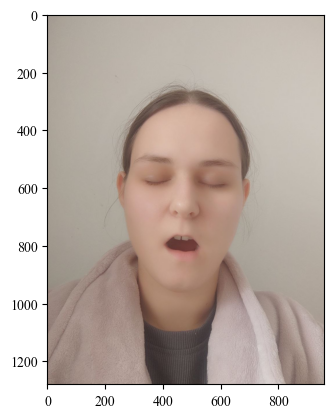

In [1001]:
plt.imshow(orig_img)

In [1002]:
np.unique(seg_mask)

array([ 0,  1,  2,  3,  7,  8, 10, 11, 12, 13, 14, 16, 17], dtype=uint8)

In [1003]:
seg_mask_eyes_raw = seg_mask.copy()
seg_mask_brow_raw = seg_mask.copy()
seg_mask_mouth_raw = seg_mask.copy()
seg_mask_nose_raw = seg_mask.copy()
seg_mask_face_raw = seg_mask.copy()

seg_mask_eyes_raw[(seg_mask_eyes_raw != 4) & (seg_mask_eyes_raw != 5)] = 0
seg_mask_brow_raw[(seg_mask_brow_raw != 2) & (seg_mask_brow_raw != 3)] = 0
seg_mask_mouth_raw[(seg_mask_mouth_raw != 11) & (seg_mask_mouth_raw != 12) & (seg_mask_mouth_raw != 13)] = 0
seg_mask_nose_raw[seg_mask_nose_raw != 10] = 0
seg_mask_face_raw[seg_mask_face_raw != 1] = 0


In [1004]:
def find_part_rect(part_seg_mask):
    contours, _ = cv2.findContours(part_seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) < 1:
        return np.asarray([0, 0, 0, 0])
    x, y, w, h = cv2.boundingRect(contours[0][:,0,:]) 
    
    return np.asarray([x, y, w, h])

def left_right_eye(seg_mask_eyes):
    cnt, _ = cv2.findContours(seg_mask_eyes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(cnt) < 1:
        return np.asarray([0,0,0,0]), np.asarray([0,0,0,0]) 
    
    if len(cnt) == 2:
        eyes_rects_list = [np.asarray(cv2.boundingRect(c[:,0,:])) for c in cnt]
        eyes_rects = np.array(eyes_rects_list)
        
        eyes_rects = eyes_rects[eyes_rects[:, 0].argsort()]
        return eyes_rects[0], eyes_rects[1]
    
    elif len(cnt) == 1:
        eye_rect = np.asarray(cv2.boundingRect(cnt[0][:, 0, :]))
        return eye_rect, np.asarray([0,0,0,0]) 
    else:
        return np.asarray([0,0,0,0]), np.asarray([0,0,0,0]) 


In [1005]:
face_rect = find_part_rect(seg_mask_face_raw)
left_eye_rect, right_eye_rect = left_right_eye(seg_mask_eyes_raw)
left_brow_rect, right_brow_rect = left_right_eye(seg_mask_brow_raw)
mouth_rect = find_part_rect(seg_mask_mouth_raw)
nose_rect = find_part_rect(seg_mask_nose_raw)

In [1006]:
def calculate_centroids(part_seg_mask):
    contours, _ = cv2.findContours(part_seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    centroids = []
    
    if not contours:
        return centroids

    for c in contours:
        M = cv2.moments(c)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            centroids.append((cX, cY))
            
    centroids.sort(key=lambda p: p[0])
    
    return centroids


def draw_feature(image, rect, label, color, centroid=None, centroid_color=None):
    if rect is not None and np.any(rect != 0):
        x, y, w, h = rect
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 4)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        if centroid:
            c_color = centroid_color if centroid_color is not None else color
            cv2.circle(image, centroid, 15, c_color, -1)
            cv2.putText(image, f"{label} C", (centroid[0] + 20, centroid[1] - 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, c_color, 2)
            
def draw_feature_ua(image_np, rect, label, color, centroid=None, centroid_color=None, thickness=4):
    if rect is not None and np.any(rect != 0):
        x, y, w, h = rect
        cv2.rectangle(image_np, (x, y), (x + w, y + h), color, thickness)
        if centroid:
            c_color = centroid_color if centroid_color is not None else color
            cv2.circle(image_np, centroid, 10, c_color, -1)
            cv2.putText(image_np, "C", (centroid[0] + 15, centroid[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, c_color, 2)

        pil_img = Image.fromarray(image_np)
        
        draw = ImageDraw.Draw(pil_img)
        
        draw.text((x, y - 30), label, font=FONT, fill=color)
        
        return np.array(pil_img)
    
    return image_np

In [1007]:
def create_proportional_rect(centroid, target_width, aspect_ratio):
    if not centroid: return np.array([0, 0, 0, 0])
    target_height = target_width * aspect_ratio
    new_x = centroid[0] - target_width / 2
    new_y = centroid[1] - target_height / 2
    return np.array([new_x, new_y, target_width, target_height]).astype(int)

In [1008]:
def estimate_missing_eye(found_eye_rect, found_eye_centroid, face_rect):
    face_center_x = face_rect[0] + face_rect[2] / 2
    dist_to_center = face_center_x - found_eye_centroid[0]
    estimated_centroid_x = int(face_center_x + dist_to_center)
    estimated_centroid_y = found_eye_centroid[1]
    estimated_centroid = (estimated_centroid_x, estimated_centroid_y)
    
    w, h = found_eye_rect[2], found_eye_rect[3]
    est_x = estimated_centroid_x - w / 2
    est_y = estimated_centroid_y - h / 2
    estimated_rect = np.array([est_x, est_y, w, h]).astype(int)
    
    return estimated_rect, estimated_centroid

def estimate_eyes_from_landmarks(brow_rects, nose_rect):
    left_brow_rect, right_brow_rect = brow_rects
    
    if (left_brow_rect is None and right_brow_rect is None) or nose_rect is None:
        return None, None

    brow_bottom_y_list = []
    if left_brow_rect is not None: brow_bottom_y_list.append(left_brow_rect[1] + left_brow_rect[3])
    if right_brow_rect is not None: brow_bottom_y_list.append(right_brow_rect[1] + right_brow_rect[3])
    
    eye_y_top = int(np.mean(brow_bottom_y_list))
    eye_y_bottom = int(nose_rect[1] + nose_rect[3] / 2)
    
    eye_height = eye_y_bottom - eye_y_top
    if eye_height <= 0: 
        return None, None

    est_left, est_right = None, None

    if left_brow_rect is not None:
        eye_width = left_brow_rect[2]
        eye_center_x = left_brow_rect[0] + left_brow_rect[2] / 2
        eye_x = int(eye_center_x - eye_width / 2)
        
        rect = np.array([eye_x, eye_y_top, eye_width, eye_height])
        centroid = (int(eye_center_x), int(eye_y_top + eye_height / 2))
        est_left = (rect, centroid)

    if right_brow_rect is not None:
        eye_width = right_brow_rect[2]
        eye_center_x = right_brow_rect[0] + right_brow_rect[2] / 2
        eye_x = int(eye_center_x - eye_width / 2)

        rect = np.array([eye_x, eye_y_top, eye_width, eye_height])
        centroid = (int(eye_center_x), int(eye_y_top + eye_height / 2))
        est_right = (rect, centroid)
        
    return est_left, est_right


In [1009]:
def adjust_features_by_proportion(face_rect, eye_data, mouth_data, brow_data, nose_data):
    left_eye_rect, right_eye_rect, left_eye_c, right_eye_c = eye_data
    mouth_rect, mouth_c = mouth_data
    left_brow_rect, right_brow_rect, _, _ = brow_data
    nose_rect, _ = nose_data
    
    if not left_eye_c and not right_eye_c:
        est_left, est_right = estimate_eyes_from_landmarks((left_brow_rect, right_brow_rect), nose_rect)
        if est_left: left_eye_rect, left_eye_c = est_left
        if est_right: right_eye_rect, right_eye_c = est_right

    if face_rect is not None and np.any(face_rect != 0):
        if left_eye_c and not right_eye_c:
            right_eye_rect, right_eye_c = estimate_missing_eye(left_eye_rect, left_eye_c, face_rect)
        elif right_eye_c and not left_eye_c:
            left_eye_rect, left_eye_c = estimate_missing_eye(right_eye_rect, right_eye_c, face_rect)

    adj_left_eye, adj_right_eye, adj_mouth = left_eye_rect, right_eye_rect, mouth_rect
    if face_rect is not None and np.any(face_rect != 0):
        face_width = face_rect[2]
        ideal_eye_width = face_width / 5.0
        
        if left_eye_rect is not None and left_eye_c is not None:
            aspect_ratio = left_eye_rect[3] / left_eye_rect[2] if left_eye_rect[2] > 0 else 0.6
            adj_left_eye = create_proportional_rect(left_eye_c, ideal_eye_width, aspect_ratio)

        if right_eye_rect is not None and right_eye_c is not None:
            aspect_ratio = right_eye_rect[3] / right_eye_rect[2] if right_eye_rect[2] > 0 else 0.6
            adj_right_eye = create_proportional_rect(right_eye_c, ideal_eye_width, aspect_ratio)
    
        if left_eye_c and right_eye_c and mouth_rect is not None:
            ideal_mouth_width = abs(right_eye_c[0] - left_eye_c[0])
            aspect_ratio = mouth_rect[3] / mouth_rect[2] if mouth_rect[2] > 0 else 0.4
            adj_mouth = create_proportional_rect(mouth_c, ideal_mouth_width, aspect_ratio)

    return (adj_left_eye, adj_right_eye, adj_mouth), (left_eye_c, right_eye_c, mouth_c)


In [1010]:
eye_centroids = calculate_centroids(seg_mask_eyes_raw)
mouth_centroids = calculate_centroids(seg_mask_mouth_raw)
brow_centroids = calculate_centroids(seg_mask_brow_raw)
nose_centroids = calculate_centroids(seg_mask_nose_raw)

initial_left_c = eye_centroids[0] if len(eye_centroids) > 0 else None
initial_right_c = eye_centroids[1] if len(eye_centroids) > 1 else None
initial_mouth_c = mouth_centroids[0] if mouth_centroids else None
initial_left_brow_c = brow_centroids[0] if len(brow_centroids) > 0 else None
initial_right_brow_c = brow_centroids[1] if len(brow_centroids) > 1 else None
initial_nose_c = nose_centroids[0] if nose_centroids else None

(adj_left_eye, adj_right_eye, adj_mouth), (final_left_c, final_right_c, _) = adjust_features_by_proportion(
    face_rect,
    (left_eye_rect, right_eye_rect, initial_left_c, initial_right_c),
    (mouth_rect, initial_mouth_c),
    (left_brow_rect, right_brow_rect, initial_left_brow_c, initial_right_brow_c),
    (nose_rect, initial_nose_c)
)

img_display = orig_img.copy()
# draw_feature(img_display, face_rect, "Face", (0, 0, 255))
# # draw_feature(img_display, left_brow_rect, "L Brow", (255, 0, 255), initial_left_brow_c)
# # draw_feature(img_display, right_brow_rect, "R Brow", (0, 255, 255), initial_right_brow_c)
# # draw_feature(img_display, nose_rect, "Nose", (255, 255, 255), initial_nose_c)
# draw_feature(img_display, adj_mouth, "Mouth", (255, 0, 0), initial_mouth_c)

# if final_left_c:
#     label, color, thickness = ("L Eye", (0, 255, 0), 4) 
#     if not initial_left_c:
#         label, color, thickness = ("Est. L Eye", (0, 165, 255), 2)
#     draw_feature(img_display, adj_left_eye, label, color, final_left_c)

# if final_right_c:
#     label, color, thickness = ("R Eye", (255, 255, 0), 4) 
#     if not initial_right_c:
#         label, color, thickness = ("Est. R Eye", (255, 165, 0), 2)
#     draw_feature(img_display, adj_right_eye, label, color, final_right_c)

# plt.figure(figsize=(12, 12))
# plt.imshow(img_display)
# plt.title("Full Facial Feature Analysis with Landmark-based Estimation")
# plt.axis('off')
# plt.show()

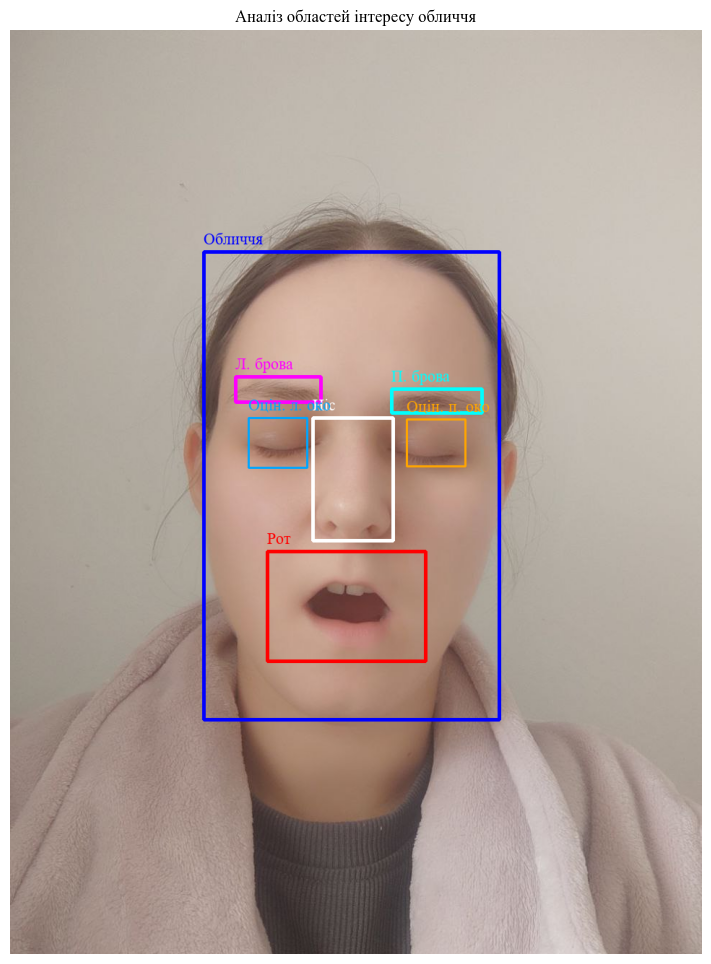

In [1011]:
img_display = draw_feature_ua(img_display, face_rect, "Обличчя", (0, 0, 255))
img_display = draw_feature_ua(img_display, left_brow_rect, "Л. брова", (255, 0, 255))
img_display = draw_feature_ua(img_display, right_brow_rect, "П. брова", (0, 255, 255))
img_display = draw_feature_ua(img_display, nose_rect, "Ніс", (255, 255, 255))
img_display = draw_feature_ua(img_display, adj_mouth, "Рот", (255, 0, 0))

if final_left_c:
    label, color, thickness = ("Л. око", (0, 255, 0), 4) 
    if not initial_left_c: 
        label, color, thickness = ("Оцін. л. око", (0, 165, 255), 2)
    img_display = draw_feature_ua(img_display, adj_left_eye, label, color, thickness=thickness)

if final_right_c:
    label, color, thickness = ("П. око", (255, 255, 0), 4)
    if not initial_right_c:
        label, color, thickness = ("Оцін. п. око", (255, 165, 0), 2)
    img_display = draw_feature_ua(img_display, adj_right_eye, label, color, thickness=thickness)

plt.figure(figsize=(12, 12))
plt.imshow(img_display)
plt.title("Аналіз областей інтересу обличчя")
plt.axis('off')
plt.show()

In [1012]:
# ніс - 10, брови - 2

In [1013]:
# def rect_to_rotated_box_points(rect_xywh):
#     x, y, w, h = float(rect_xywh[0]), float(rect_xywh[1]), float(rect_xywh[2]), float(rect_xywh[3])
    
#     center = (x + w / 2, y + h / 2)
#     size = (w, h)
#     angle = 0.0

#     rotated_rect_info = (center, size, angle) 
    
#     return cv2.boxPoints(rotated_rect_info).astype(np.int32)

# def get_moment_and_rotated_rect(binary_part_mask):
#     """
#     Обчислює моменти, центроїд та орієнтований мінімальний прямокутник для бінарної маски.
#     Повертає кортеж: (moments, centroid_xy, rotated_rect_info, box_points)
#     """
#     contours, _ = cv2.findContours(binary_part_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if not contours:
#         return None
    
#     largest_contour = max(contours, key=cv2.contourArea)

#     temp_mask_for_moments = np.zeros_like(binary_part_mask)
#     cv2.drawContours(temp_mask_for_moments, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
#     M = cv2.moments(temp_mask_for_moments)

#     if M["m00"] == 0:  
#         return None

#     cX = int(M["m10"] / M["m00"])
#     cY = int(M["m01"] / M["m00"])

#     rotated_rect = cv2.minAreaRect(largest_contour)
    
#     box = cv2.boxPoints(rotated_rect).astype(np.int32)

#     return M, (cX, cY), rotated_rect, box 

# def get_fallback_eye_rects(face_rect, left_eye_raw_rect_xywh, right_eye_raw_rect_xywh, img_shape):
#     """
#     Обчислює або уточнює вісь-вирівняні прямокутники очей, використовуючи face_rect як базову лінію.
#     Ця функція призначена для сценаріїв, коли детектор не знайшов одного або обох очей.
#     """
#     fx, fy, fw, fh = int(face_rect[0]), int(face_rect[1]), int(face_rect[2]), int(face_rect[3])
#     img_h, img_w = img_shape[:2]

#     target_eye_width = int(fw / 5.0)
#     target_eye_height = int(target_eye_width * 0.6)

#     center_face_x = fx + fw // 2
#     center_face_y = fy + fh // 2

#     def create_rect_from_center_and_size(cx, cy, w, h):
#         x = max(0, cx - w // 2)
#         y = max(0, cy - h // 2)
#         w_final = min(w, img_w - x)
#         h_final = min(h, img_h - y)
#         return [int(x), int(y), int(w_final), int(h_final)]

#     adjusted_left_eye_xywh = left_eye_raw_rect_xywh
#     adjusted_right_eye_xywh = right_eye_raw_rect_xywh

#     if adjusted_left_eye_xywh is not None and adjusted_right_eye_xywh is None:
#         lx, ly, lw, lh = int(adjusted_left_eye_xywh[0]), int(adjusted_left_eye_xywh[1]), \
#                          int(adjusted_left_eye_xywh[2]), int(adjusted_left_eye_xywh[3])
#         center_lx = lx + lw // 2
#         center_ly = ly + lh // 2
#         dist_x = center_face_x - center_lx 
#         mirror_cx = center_face_x + dist_x
#         adjusted_right_eye_xywh = create_rect_from_center_and_size(mirror_cx, center_ly, target_eye_width, target_eye_height)

#     elif adjusted_right_eye_xywh is not None and adjusted_left_eye_xywh is None:
#         rx, ry, rw, rh = int(adjusted_right_eye_xywh[0]), int(adjusted_right_eye_xywh[1]), \
#                          int(adjusted_right_eye_xywh[2]), int(adjusted_right_eye_xywh[3])
#         center_rx = rx + rw // 2
#         center_ry = ry + rh // 2
#         dist_x = center_rx - center_face_x
#         mirror_cx = center_face_x - dist_x
#         adjusted_left_eye_xywh = create_rect_from_center_and_size(mirror_cx, center_ry, target_eye_width, target_eye_height)

#     if adjusted_left_eye_xywh is None and adjusted_right_eye_xywh is None:
#         eye_y_center = fy + int(fh * 0.3) 
#         left_eye_x_center = fx + int(fw * 0.25) 
#         right_eye_x_center = fx + int(fw * 0.75) 

#         adjusted_left_eye_xywh = create_rect_from_center_and_size(left_eye_x_center, eye_y_center, target_eye_width, target_eye_height)
#         adjusted_right_eye_xywh = create_rect_from_center_and_size(right_eye_x_center, eye_y_center, target_eye_width, target_eye_height)
        
#     return adjusted_left_eye_xywh, adjusted_right_eye_xywh

# def get_fallback_mouth_rect(face_rect, img_shape):
    
#     fx, fy, fw, fh = int(face_rect[0]), int(face_rect[1]), int(face_rect[2]), int(face_rect[3])
#     img_h, img_w = img_shape[:2]

#     mouth_w_ratio = 0.4
#     mouth_h_ratio = 0.15
    
#     mouth_x_center = fx + fw // 2
#     mouth_y_center = fy + int(fh * 0.75) 
    
#     mouth_w = int(fw * mouth_w_ratio)
#     mouth_h = int(fh * mouth_h_ratio)

#     mouth_x = max(0, mouth_x_center - mouth_w // 2)
#     mouth_y = max(0, mouth_y_center - mouth_h // 2)
#     mouth_w_final = min(mouth_w, img_w - mouth_x)
#     mouth_h_final = min(mouth_h, img_h - mouth_y)

#     return [int(mouth_x), int(mouth_y), int(mouth_w_final), int(mouth_h_final)]

In [1014]:
# seg_mask_face_binary = np.zeros_like(seg_mask, dtype=np.uint8)
# seg_mask_face_binary[seg_mask != 0] = 255 

# seg_mask_eyes_binary = np.zeros_like(seg_mask, dtype=np.uint8)
# seg_mask_eyes_binary[(seg_mask == 4) | (seg_mask == 5)] = 255 

# seg_mask_mouth_binary = np.zeros_like(seg_mask, dtype=np.uint8)
# seg_mask_mouth_binary[(seg_mask == 11) | (seg_mask == 12) | (seg_mask == 13)] = 255 

# print("Binary masks created for face, eyes, and mouth.")

In [1015]:
# left_eye_rect, right_eye_rect = left_right_eye(seg_mask_eyes)
# mouth_rect = find_part_rect(seg_mask_mouth)
# face_rect = find_part_rect(seg_mask_face)

In [1016]:
# cnt, _ = cv2.findContours(seg_mask_eyes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# tmp_mask = np.zeros(shape=seg_mask_eyes.shape, dtype=seg_mask_eyes.dtype)
# tmp_mask = cv2.drawContours(tmp_mask, cnt, 1, color=255, thickness=cv2.FILLED)

In [1017]:
# face_contours, _ = cv2.findContours(seg_mask_face_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# face_rect_xywh = None
# if face_contours:
#     largest_face_contour = max(face_contours, key=cv2.contourArea)
#     face_rect_xywh = cv2.boundingRect(largest_face_contour)
# else:
#     print("Warning: No face detected. Fallback for eyes/mouth might not be accurate.")

# left_eye_final_data = None
# right_eye_final_data = None
# mouth_final_data = None
# face_final_data = None

# if face_rect_xywh is not None:
#     fx, fy, fw, fh = face_rect_xywh
#     face_centroid = (fx + fw // 2, fy + fh // 2)
#     face_box_points = rect_to_rotated_box_points(face_rect_xywh)
#     face_rotated_rect_info = (None, (fw, fh), 0.0) 
#     face_final_data = (face_box_points, face_centroid, face_rotated_rect_info)
#     print(f"Face bounding box obtained: {face_rect_xywh}")

# eye_contours, _ = cv2.findContours(seg_mask_eyes_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# detected_eyes_full_info = [] 

# for contour in eye_contours:
#     temp_eye_mask = np.zeros_like(seg_mask_eyes_binary)
#     cv2.drawContours(temp_eye_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
#     part_info = get_moment_and_rotated_rect(temp_eye_mask)
#     if part_info:
#         detected_eyes_full_info.append(part_info)

# if len(detected_eyes_full_info) == 2:
#     detected_eyes_full_info.sort(key=lambda x: x[1][0]) 
    
#     left_eye_final_data = (detected_eyes_full_info[0][3], detected_eyes_full_info[0][1], detected_eyes_full_info[0][2])
#     right_eye_final_data = (detected_eyes_full_info[1][3], detected_eyes_full_info[1][1], detected_eyes_full_info[1][2])
#     print(f"Detected both eyes using moments and rotated bounding boxes.")

# elif len(detected_eyes_full_info) == 1 and face_rect_xywh is not None:
#     detected_eye_full_info = detected_eyes_full_info[0]
    
#     detected_eye_xywh = cv2.boundingRect(detected_eye_full_info[3])
    
#     if detected_eye_xywh[0] < face_rect_xywh[0] + face_rect_xywh[2] / 2: 
#         left_eye_detected_for_fallback_xywh = detected_eye_xywh
#         right_eye_detected_for_fallback_xywh = None
#         left_eye_final_data = (detected_eye_full_info[3], detected_eye_full_info[1], detected_eye_full_info[2]) 
#     else: 
#         left_eye_detected_for_fallback_xywh = None
#         right_eye_detected_for_fallback_xywh = detected_eye_xywh
#         right_eye_final_data = (detected_eye_full_info[3], detected_eye_full_info[1], detected_eye_full_info[2]) 

#     inferred_left_eye_xywh, inferred_right_eye_xywh = get_fallback_eye_rects(
#         face_rect_xywh, 
#         left_eye_detected_for_fallback_xywh, 
#         right_eye_detected_for_fallback_xywh, 
#         orig_img.shape
#     )
    
#     if left_eye_final_data is None and inferred_left_eye_xywh is not None:
#         centroid_l = (inferred_left_eye_xywh[0] + inferred_left_eye_xywh[2]//2, inferred_left_eye_xywh[1] + inferred_left_eye_xywh[3]//2)
#         size_l = (inferred_left_eye_xywh[2], inferred_left_eye_xywh[3])
#         left_eye_final_data = (rect_to_rotated_box_points(inferred_left_eye_xywh), centroid_l, (None, size_l, 0))
#         print(f"Detected one eye using moments and inferred the other (left). Fallback rect: {inferred_left_eye_xywh}")
    
#     if right_eye_final_data is None and inferred_right_eye_xywh is not None:
#         centroid_r = (inferred_right_eye_xywh[0] + inferred_right_eye_xywh[2]//2, inferred_right_eye_xywh[1] + inferred_right_eye_xywh[3]//2)
#         size_r = (inferred_right_eye_xywh[2], inferred_right_eye_xywh[3])
#         right_eye_final_data = (rect_to_rotated_box_points(inferred_right_eye_xywh), centroid_r, (None, size_r, 0))
#         print(f"Detected one eye using moments and inferred the other (right). Fallback rect: {inferred_right_eye_xywh}")

# elif len(detected_eyes_full_info) == 0 and face_rect_xywh is not None:
#     inferred_left_eye_xywh, inferred_right_eye_xywh = get_fallback_eye_rects(face_rect_xywh, None, None, orig_img.shape)
    
#     centroid_l = (inferred_left_eye_xywh[0] + inferred_left_eye_xywh[2]//2, inferred_left_eye_xywh[1] + inferred_left_eye_xywh[3]//2)
#     size_l = (inferred_left_eye_xywh[2], inferred_left_eye_xywh[3])
#     left_eye_final_data = (rect_to_rotated_box_points(inferred_left_eye_xywh), centroid_l, (None, size_l, 0))

#     centroid_r = (inferred_right_eye_xywh[0] + inferred_right_eye_xywh[2]//2, inferred_right_eye_xywh[1] + inferred_right_eye_xywh[3]//2)
#     size_r = (inferred_right_eye_xywh[2], inferred_right_eye_xywh[3])
#     right_eye_final_data = (rect_to_rotated_box_points(inferred_right_eye_xywh), centroid_r, (None, size_r, 0))
#     print(f"Inferred both eyes using fallback.")

# else:
#     print(f"Warning: Could not robustly process eyes. Detected {len(detected_eyes_full_info)} eye parts. Face rect was {face_rect_xywh}.")


# mouth_detected_full_info = get_moment_and_rotated_rect(seg_mask_mouth_binary)
# if mouth_detected_full_info:
#     mouth_final_data = (mouth_detected_full_info[3], mouth_detected_full_info[1], mouth_detected_full_info[2])
#     print("Detected mouth using moments and rotated bounding box.")
# elif face_rect_xywh is not None:
#     inferred_mouth_xywh = get_fallback_mouth_rect(face_rect_xywh, orig_img.shape)
#     centroid_m = (inferred_mouth_xywh[0] + inferred_mouth_xywh[2]//2, inferred_mouth_xywh[1] + inferred_mouth_xywh[3]//2)
#     size_m = (inferred_mouth_xywh[2], inferred_mouth_xywh[3])
#     mouth_final_data = (rect_to_rotated_box_points(inferred_mouth_xywh), centroid_m, (None, size_m, 0))
#     print("Inferred mouth using fallback.")
# else:
#     print("Warning: Could not process mouth. No face detected or no fallback available.")

# print("Facial parts processing complete.")

In [1018]:
# plt.imshow(tmp_mask)
# cv2.moments(tmp_mask)

In [1019]:
# mouth_moments = cv2.moments(seg_mask_mouth)

# mouth_x = mouth_moments["m10"] // mouth_moments["m00"]
# mouth_y = mouth_moments["m01"] // mouth_moments["m00"]

In [1020]:
# mxy = np.asarray([mouth_x, mouth_y], dtype=np.int32)


In [1021]:
# img = orig_img.copy()
# img = cv2.rectangle(img.copy(), left_eye_rect[0:2],  left_eye_rect[0:2]+left_eye_rect[2:4],
#                     color=(255,255,0), thickness=6)

# img = cv2.rectangle(img.copy(), right_eye_rect[0:2],  right_eye_rect[0:2]+right_eye_rect[2:4],
#                     color=(255,255,0), thickness=6)

# img = cv2.rectangle(img.copy(), mouth_rect[0:2],  mouth_rect[0:2]+mouth_rect[2:4],
#                     color=(255,255,0), thickness=6)

# img = cv2.drawMarker(img, mxy, color=(255, 0, 0), 
#                      markerType=cv2.MARKER_CROSS, 
#                      markerSize=10, thickness=10)

# img = cv2.rectangle(img.copy(), face_rect[0:2],  face_rect[0:2]+face_rect[2:4],
#                     color=(0,0,255), thickness=6)

In [1022]:
# plt.imshow(img)

In [1023]:
# img_with_rects = orig_img.copy()

# def draw_part_info(img, part_data, color_rect, color_centroid, label_prefix=""):
#     if part_data:
#         box_points = part_data[0]
#         centroid = part_data[1]
        
#         cv2.polylines(img, [box_points], True, color_rect, 2)
        
#         cv2.drawMarker(img, centroid, color_centroid, 
#                        markerType=cv2.MARKER_CROSS, 
#                        markerSize=10, thickness=2)
        
#         rect_info = part_data[2] 
#         if rect_info and rect_info[2] is not None: 
#             print(f"{label_prefix}: Centroid={centroid}, RotatedRect={rect_info}, BoxPoints={box_points}")
#         else:
#             x,y,w,h = cv2.boundingRect(box_points)
#             print(f"{label_prefix}: Centroid={centroid}, FallbackRect=(x={x},y={y},w={w},h={h}), BoxPoints={box_points}")


# draw_part_info(img_with_rects, face_final_data, (0, 255, 0), (0, 0, 255), "Face") 
# draw_part_info(img_with_rects, left_eye_final_data, (0, 255, 255), (0, 0, 255), "Left Eye") 
# draw_part_info(img_with_rects, right_eye_final_data, (0, 255, 255), (0, 0, 255), "Right Eye") 
# draw_part_info(img_with_rects, mouth_final_data, (255, 0, 255), (0, 0, 255), "Mouth") 

# plt.figure(figsize=(10, 8))
# plt.imshow(img_with_rects)
# plt.title("Detected Parts with Rotated Bounding Boxes and Centroids")
# plt.axis('off')
# plt.show()
